De même que pour le CNN , nous avons le même SVM pour la modulation et les spectro afin de comparer équitablement.


Importation des bibliothèques

In [1]:


import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.metrics import precision_score




Importation du corpus train et test pour la classe malade et sain

In [8]:
def load_and_preprocess_data(folder_path, label, img_rows=28, img_cols=28):
    images = []
    labels = []

    for filename in folder_path:

        img = cv2.imread(filename, 0).astype(np.uint8)
        img = cv2.resize(img, (img_rows, img_cols))
        images.append(img.flatten())
        labels.append(label)

    return images, labels
list_malade = glob.glob('malade_spectro_glides/test/*')
list_ok = glob.glob('sain_spectro_glides/test/*')
list_malade_train = glob.glob('malade_spectro_glides/train/*')
list_ok_train = glob.glob('sain_spectro_glides/train/*')


# 'malade' train
malade_train_images, malade_train_labels = load_and_preprocess_data(list_malade_train, label=0)

# 'non_malade' train
non_malade_train_images, non_malade_train_labels = load_and_preprocess_data(list_ok_train, label=1)

# 'malade' test
malade_test_images, malade_test_labels = load_and_preprocess_data(list_malade, label=0)

# 'non_malade' test
non_malade_test_images, non_malade_test_labels = load_and_preprocess_data(list_ok, label=1)


x_train = np.concatenate([malade_train_images, non_malade_train_images], axis=0)
y_train = np.concatenate([malade_train_labels, non_malade_train_labels], axis=0)

x_test = np.concatenate([malade_test_images, non_malade_test_images], axis=0)
y_test = np.concatenate([malade_test_labels, non_malade_test_labels], axis=0)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


Créer et entraîner le modèle SVM et visualiser la matrice de confusion

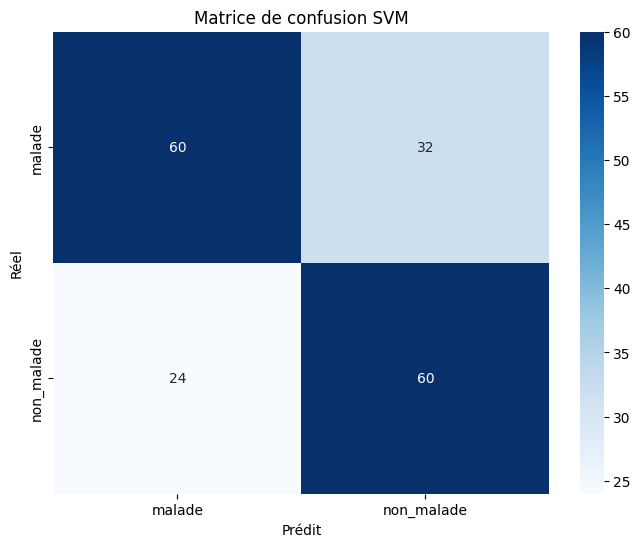

Precision: 0.6522


In [9]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(x_train_scaled, y_train)

# Prédictions
y_pred_svm = svm_model.predict(x_test_scaled)

# Matrice de confusion
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Visualiser
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Matrice de confusion SVM')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Calculer precision
precision = precision_score(y_test, y_pred_svm)
print(f'Precision: {precision:.4f}')

les données mal classées

In [11]:
malade_image_names = [os.path.basename(filename) for filename in list_malade_train]
non_malade_image_names = [os.path.basename(filename) for filename in list_ok_train]

# Sauvegarder les données mal classées dans un fichier CSV
misclassified_data_svm = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_svm[i]:
        actual_class = 'malade' if y_test[i] == 0 else 'non_malade'
        predicted_class = 'malade' if y_pred_svm[i] == 0 else 'non_malade'
        image_name = malade_image_names[i] if y_test[i] == 0 else non_malade_image_names[i - len(malade_image_names)]
        misclassified_data_svm.append([image_name, actual_class, predicted_class])

csv_file_path_svm = 'misclassified_data_svm.csv'
header_svm = ['Nom de l\'image', 'Classe Réelle', 'Classe Prédite']

with open(csv_file_path_svm, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header_svm)
    writer.writerows(misclassified_data_svm)

print(f"Données mal classées sauvegardées dans le fichier CSV : {csv_file_path_svm}")

# Afficher les données mal classées
res_svm = pd.DataFrame(misclassified_data_svm)
print(res_svm)

Données mal classées sauvegardées dans le fichier CSV : misclassified_data_svm.csv
                                                    0           1           2
0   spectrogram_SCA_F_AB08_2020_10_26_ModuleTransi...      malade  non_malade
1   spectrogram_SCA_F_AB08_2020_10_26_ModuleTransi...      malade  non_malade
2   spectrogram_SCA_F_AB08_2020_10_26_ModuleTransi...      malade  non_malade
3   spectrogram_SCA_F_AB08_2020_10_26_ModuleTransi...      malade  non_malade
4   spectrogram_SCA_F_AB20_2020_11_11_ModuleTransi...      malade  non_malade
5   spectrogram_SCA_F_AB20_2020_11_11_ModuleTransi...      malade  non_malade
6   spectrogram_SCA_F_AB20_2020_11_11_ModuleTransi...      malade  non_malade
7   spectrogram_SCA_F_AB21_2020_11_12_ModuleTransi...      malade  non_malade
8   spectrogram_SCA_F_AB21_2020_11_12_ModuleTransi...      malade  non_malade
9   spectrogram_SCA_F_AB21_2020_11_12_ModuleTransi...      malade  non_malade
10  spectrogram_SCA_F_AB21_2020_11_12_ModuleTransi...      

Le SVM s'en sort beaucoup moins bien que le spectrogramme pour la classification, particulièrement pour les malades. il y a un ecart de 15 % avec la modulation ce qui n'est pas rien. L'ecart est beaucoup plus grand qu'avec le CNN ou nous n'avons que 5% d'écart entre les deux inputs.
Vous trouverez sur Github les graphiques montrant les proportions de mal classés pour les stimulis et pour la sévérités des malades.

Lorsque nous faisons le test face à sa stabilité en inversant les pixels de l'image comme demandé par Mr Audibert nous pouvons nous apercevoir que les résultats chutent également pour les spectrogrammes.

In [2]:
def load_and_preprocess_data(folder_path, label, img_rows=28, img_cols=28):
    images = []
    labels = []

    for filename in folder_path:

        img = cv2.imread(filename, 0).astype(np.uint8)
        img = cv2.resize(img, (img_rows, img_cols))
        images.append(img.flatten())
        labels.append(label)

    return images, labels
list_malade = glob.glob('malade_mfcc_glides/test/*')
list_ok = glob.glob('sain_mfcc_glides/test/*')
list_malade_train = glob.glob('malade_mfcc_glides/train/*')
list_ok_train = glob.glob('sain_mfcc_glides/train/*')


# 'malade' train
malade_train_images, malade_train_labels = load_and_preprocess_data(list_malade_train, label=0)

# 'non_malade' train
non_malade_train_images, non_malade_train_labels = load_and_preprocess_data(list_ok_train, label=1)

# 'malade' test
malade_test_images, malade_test_labels = load_and_preprocess_data(list_malade, label=0)

# 'non_malade' test
non_malade_test_images, non_malade_test_labels = load_and_preprocess_data(list_ok, label=1)


x_train = np.concatenate([malade_train_images, non_malade_train_images], axis=0)
y_train = np.concatenate([malade_train_labels, non_malade_train_labels], axis=0)

x_test = np.concatenate([malade_test_images, non_malade_test_images], axis=0)
y_test = np.concatenate([malade_test_labels, non_malade_test_labels], axis=0)
for i in range(len(x_train)):
    np.random.shuffle(x_train[i])

# Mélanger les pixels à l'intérieur de chaque vecteur dans x_test
for i in range(len(x_test)):
    np.random.shuffle(x_test[i])
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
# Mélanger les pixels à l'intérieur de chaque vecteur dans x_train

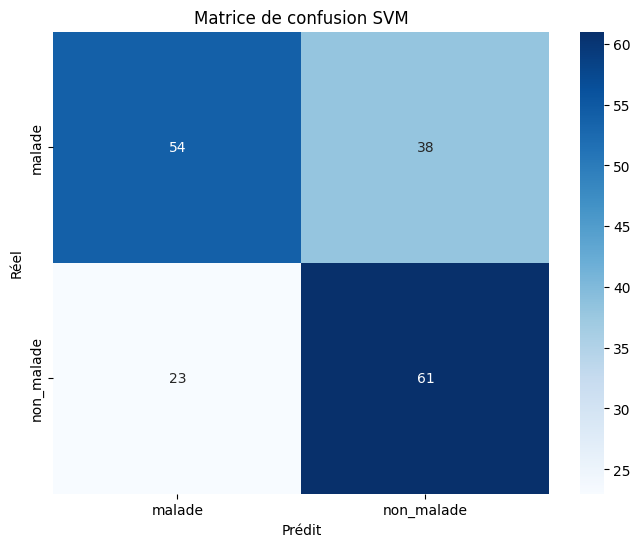

Precision: 0.6162


In [3]:


svm_model = SVC(kernel='rbf', C=1, gamma='scale') 
svm_model.fit(x_train_scaled, y_train)

# Prédictions
y_pred_svm = svm_model.predict(x_test_scaled)

# Matrice de confusion
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Visualiser
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Matrice de confusion SVM')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Calculer precision
precision = precision_score(y_test, y_pred_svm)
print(f'Precision: {precision:.4f}')

